# Автоматическая суммаризация новостных статей для русского языка

## Введение

В мире, где поток информации увеличивается с каждым днём, обработка естественного языка _(Natural Language Processing, NLP)_ представляет собой ключевое направление в области искусственного интеллекта. NLP занимается разработкой методов и систем, которые позволяют компьютерам понимать и генерировать человеческий язык, тем самым облегчая взаимодействие между людьми и машинами. Задачи NLP охватывают широкий спектр действий от синтаксического анализа и семантического понимания до генерации ответов и перевода текстов. Одной из таких задач является автоматическая суммаризация текста _(Automatic Text Summarization, ATS)_, которая представляет собой процесс создания краткого и сжатого изложения длинного текста, сохраняя при этом его основное содержание и смысл. В эпоху цифровизации, когда пользователи зачастую перегружены информацией, ATS предоставляет возможность быстро получить суть документа или статьи, не тратя время на чтение всего текста.

Важность ATS в современном мире продолжает расти и в представленной работе мы рассмотрим эту задачу на конкретном примере — создание модели для автоматического составления заголовков новостных статей на русском языке. Для достижения этой цели был использован датасет "Gazeta", содержащий статьи российских новостных изданий. В работе рассмотрены различные подходы к автоматической суммаризации и выбрана наиболее эффективная модель для данной задачи.

## Теоретические основы

### Классификация методов суммаризации

Существует два основных подхода к автоматической суммаризации текста:  
  - **Extractive summarization:** Этот подход заключается в выборе ключевых предложений или фраз из исходного текста, которые затем объединяются для создания суммарного текста. Экстрактивные методы просты в реализации и требуют меньше вычислительных ресурсов, однако их результат может быть менее естественным и связным.
  - **Abstractive summarization:** В отличие от extractive подхода, данный метод предполагает создание нового текста, который передает основную идею исходного документа, используя перефразирование и генерацию новых предложений. Абстрактивная суммаризация более сложна в реализации, но позволяет получить более естественный и читаемый текст.

### Способы подготовки текста

Перед тем как начать обработку текста и его сокращение, обычно применяют ряд методов предобработки. Предобработка текста необходима для того, чтобы алгоритм мог работать с ним наиболее эффективно. Большинство методов предобработки направлены на унификацию и очистку текста.

**Основные методы предобработки** включают:
1. Приведение всех букв к нижнему регистру.
2. Удаление знаков препинания.
3. Удаление стоп-слов (слов, не несущих значимой смысловой нагрузки, таких как союзы, артикли и т.д.).
4. Стемминг (приведение однокоренных слов к общей форме путем удаления изменяемых частей слова).
5. Лемматизация (приведение однокоренных слов к их начальной форме).
6. Токенизация (преобразование текста в список предложений, а предложений в список слов). Это необходимо для работы с текстом как с последовательностью объектов, а не как со строкой.

### Методы автоматической суммаризации

Методы автоматической суммаризации можно разделить на традиционные и современные.
- **Традиционные методы** включают частотный анализ и методы на основе графов. Частотный анализ основан на подсчете частоты появления слов в тексте и выборе наиболее частотных слов для создания резюме. Методы на основе графов используют графовые структуры для представления текста и выбора ключевых предложений.

- **Современные методы** включают модели на основе глубокого обучения, такие как трансформеры. Они позволяют учитывать контекст и генерировать более осмысленные и естественные суммаризации. Методы, основанные на глубоком обучении, характеризуются тем, что они могут создавать краткие содержания, которые по смыслу близки к тем, что составлены человеком. Однако, достичь такого результата для любого входного текста весьма сложно. Это связано с большим количеством параметров, необходимостью огромного объема данных для обучения, валидации и тестирования. Все эти факторы усложняют их реализацию, увеличивают время работы и вычислительную сложность.

## Анализ и подготовка данных

### Необходимые библиотеки

In [ ]:
# Установка доп. библиотек
!pip install bert_score
!pip install pymorphy2
!pip install sacrebleu
!pip install rouge_score
!pip install accelerate -U
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Импорт библиотек
import re
import nltk
import bert_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sacrebleu import corpus_bleu
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from rouge_score import rouge_scorer
from datasets import Dataset, DatasetDict
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

### EDA

#### Описание датасета



Датасет "Gazeta" представляет собой коллекцию новостных статей с сайта www.gazeta.ru. Каждая запись включает URL новости, полный текст, заголовок, краткое резюме и дату публикации. Датасет разделён на тренировочный, тестовый и валидационный наборы, что позволяет корректно обучить и оценить модель.

Пример записи из датасета:

```python
{
  "url": "https://www.gazeta.ru/science/2020/02/14_a_12960289.shtml",
  "text": "Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий...",
  "title": "Венера, Ио или Тритон: куда полетит NASA",
  "summary": "В NASA назвали четыре миссии в дальний космос...",
  "date": "2020-02-14 16:39:11"
}
```

#### Загрузка и анализ данных

Для начала загрузим данные и изучим их структуру. Для этого будем использовать библиотеку **pandas**.
Анализ данных проведём на примере тестового набора **train_df**.

In [ ]:
train_df = pd.read_json('/content/drive/MyDrive/gazeta_train.jsonl', lines=True)

In [ ]:
# Исследование структуры данных
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52400 entries, 0 to 52399
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   url      52400 non-null  object        
 1   text     52400 non-null  object        
 2   title    52400 non-null  object        
 3   summary  52400 non-null  object        
 4   date     52400 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.0+ MB


In [ ]:
# Пример данных
train_df.head(3)

,url,text,title,summary,date
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14


In [ ]:
train_df.text[1924]

'Путешествуя по Сицилии, начинаешь понимать, почему этот остров имеет статус автономного итальянского региона. Кажется, что здесь все так же, как и на континенте, однако и еда, и вино, и акцент, и способ жизни, и привычки, и музыка оказываются совершенно иными. Если вы уже бывали на континентальной Италии, то путешествие на Сицилию даст вам богатый материал для сравнения. Если же поездка на остров ваше первое итальянское путешествие, то оно наверняка пробудит интерес к другим итальянским регионам и даст ключ к пониманию тех аспектов, которые делают Италию Италией.'

In [ ]:
# Проверка на пропущенные значения
train_df.isnull().sum()

url        0
text       0
title      0
summary    0
date       0
dtype: int64

In [ ]:
# Проверка на дубликаты
train_df.duplicated().sum()

0

#### Статистический анализ данных

Посчитаем распределение длины текстов и заголовков статей.

In [ ]:
# Добавим длину текстов и заголовков в датафреймы
train_df['text_length'] = train_df['text'].apply(len)
train_df['title_length'] = train_df['title'].apply(len)

In [ ]:
train_df['text_length'].describe()

count    52400.000000
mean      4515.325172
std       1291.271003
min        127.000000
25%       3735.000000
50%       4300.000000
75%       5123.000000
max      10434.000000
Name: text_length, dtype: float64

In [ ]:
train_df['title_length'].describe()

count    52400.000000
mean        35.122805
std         13.891914
min          4.000000
25%         24.000000
50%         32.000000
75%         46.250000
max        136.000000
Name: title_length, dtype: float64

Построим гистограммы распределения длины текстов и заголовков.

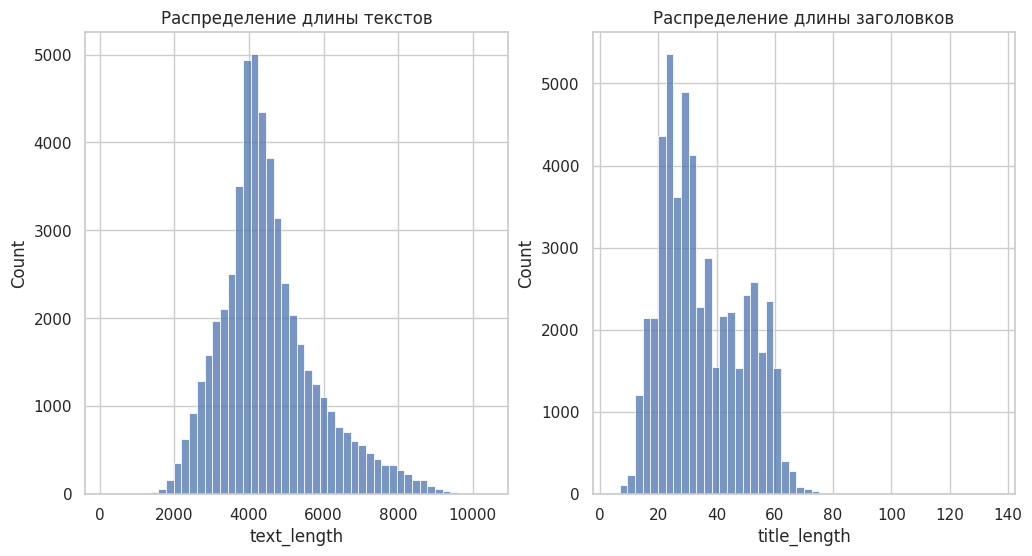

In [ ]:
# Настройка отображения графиков
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_df['text_length'], bins=50)
plt.title('Распределение длины текстов')

plt.subplot(1, 2, 2)
sns.histplot(train_df['title_length'], bins=50)
plt.title('Распределение длины заголовков')

plt.show()

### Предварительная обработка данных

#### Очистка и нормализация текстов

Удалим HTML-теги, пунктуацию и приведём тексты к нижнему регистру.

In [ ]:
# Функция для нормализации текста
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Удаление HTML-тегов
    text = re.sub(r'[^\w\s]', '', text).lower() # Удаление пунктуации и приведение к нижнему регистру
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов и пробелов по краям
    return text

In [ ]:
# Применение функции к датасету
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['cleaned_title'] = train_df['title'].apply(clean_text)

In [ ]:
train_df.head(3)

,url,text,title,summary,date,text_length,title_length,cleaned_text,cleaned_title
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39,2831,30,по итогам 2011 года чистый отток может состави...,прогноз не успевает за оттоком
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09,3194,21,российское подразделение интернеткорпорации go...,google закончил поиск
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14,4249,43,басманный районный суд москвы вечером 6 феврал...,фигуранты дела могут давить на свидетелей


#### Токенизация текстов

Разделим тексты на токены.

In [ ]:
# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train_df['tokenized_text'] = train_df['cleaned_text'].apply(word_tokenize)
train_df['tokenized_title'] = train_df['cleaned_title'].apply(word_tokenize)

In [ ]:
train_df.head(3)

,url,text,title,summary,date,text_length,title_length,cleaned_text,cleaned_title,tokenized_text,tokenized_title
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39,2831,30,по итогам 2011 года чистый отток может состави...,прогноз не успевает за оттоком,"[по, итогам, 2011, года, чистый, отток, может,...","[прогноз, не, успевает, за, оттоком]"
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09,3194,21,российское подразделение интернеткорпорации go...,google закончил поиск,"[российское, подразделение, интернеткорпорации...","[google, закончил, поиск]"
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14,4249,43,басманный районный суд москвы вечером 6 феврал...,фигуранты дела могут давить на свидетелей,"[басманный, районный, суд, москвы, вечером, 6,...","[фигуранты, дела, могут, давить, на, свидетелей]"


#### Удаление стоп-слов из текстов

Стоп-слова — это слова, которые часто встречаются в тексте, но не несут значимой смысловой нагрузки и могут быть исключены из анализа текста. В основном, это предлоги, союзы, местоимения и другие служебные части речи.

In [ ]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
rus_stopwords = set(stopwords.words('russian'))

В списке стоп-слов для русского языка, предоставленном библиотекой NLTK, содержится 151 слово. Проведя исследование и анализ других аналогичных списков, найденных на просторах сети, был составлен дополнительный список стоп-слов для использования в работе.

In [ ]:
# Дополнительные стоп-слова
additional_stopwords = [
    'алло', 'буду', 'будут', 'будь', 'вами', 'ваш', 'ваша', 'ваше', 'ваши',
    'весь', 'возможно', 'вон', 'вообще', 'впрочем', 'всем', 'всему', 'всею',
    'вся', 'всё', 'действительно', 'другие', 'еще', 'ещё', 'ею', 'её', 'затем',
    'зато', 'значит', 'ими', 'итак', 'каждая', 'каждое', 'каждые', 'кем',
    'кого', 'ком', 'кому', 'конечно', 'которая', 'которого', 'которой',
    'которые', 'который', 'которых', 'кроме', 'мною', 'мог', 'мои', 'мой',
    'мочь', 'моё', 'наверное', 'наконец', 'нам', 'нами', 'например', 'наш',
    'наша', 'наше', 'наши', 'нем', 'нему', 'нередко', 'нею', 'неё', 'никто',
    'ними', 'оба', 'однако', 'одной', 'оно', 'особенно', 'откуда', 'очень',
    'поэтому', 'сама', 'сами', 'самим', 'самими', 'самих', 'само', 'самой',
    'самому', 'саму', 'свое', 'своего', 'своей', 'свои', 'своих', 'свой',
    'своё', 'сих', 'следовательно', 'слишком', 'собой', 'сразу', 'та',
    'такая', 'также', 'таки', 'такие', 'такое', 'твои', 'твой', 'твоя',
    'твоё', 'те', 'тебе', 'теми', 'тех', 'тобой', 'тобою', 'тому', 'ту',
    'хотя', 'чаще', 'чему', 'эта', 'этим', 'этими', 'этих', 'это', 'этому'
]

In [ ]:
# Добавление дополнительных стоп-слов к существующему словарю стоп-слов
rus_stopwords.update(additional_stopwords)

In [ ]:
# Функция для удаления стоп-слов
def remove_stopwords(tokens):
    return [token for token in tokens if token not in rus_stopwords]

In [ ]:
train_df['tokenized_text_wo_stop_words'] = train_df['tokenized_text'].apply(remove_stopwords)
train_df['tokenized_title_wo_stop_words'] = train_df['tokenized_title'].apply(remove_stopwords)

In [ ]:
train_df.head(3)

,url,text,title,summary,date,text_length,title_length,cleaned_text,cleaned_title,tokenized_text,tokenized_title,tokenized_text_wo_stop_words,tokenized_title_wo_stop_words
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39,2831,30,по итогам 2011 года чистый отток может состави...,прогноз не успевает за оттоком,"[по, итогам, 2011, года, чистый, отток, может,...","[прогноз, не, успевает, за, оттоком]","[итогам, 2011, года, чистый, отток, составить,...","[прогноз, успевает, оттоком]"
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09,3194,21,российское подразделение интернеткорпорации go...,google закончил поиск,"[российское, подразделение, интернеткорпорации...","[google, закончил, поиск]","[российское, подразделение, интернеткорпорации...","[google, закончил, поиск]"
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14,4249,43,басманный районный суд москвы вечером 6 феврал...,фигуранты дела могут давить на свидетелей,"[басманный, районный, суд, москвы, вечером, 6,...","[фигуранты, дела, могут, давить, на, свидетелей]","[басманный, районный, суд, москвы, вечером, 6,...","[фигуранты, дела, могут, давить, свидетелей]"


In [ ]:
print(train_df.iloc[2]['tokenized_title_wo_stop_words'])

['фигуранты', 'дела', 'могут', 'давить', 'свидетелей']


#### Лемматизация текстов

Применим лемматизацию для приведения слов к их начальной форме.

In [ ]:
morph = MorphAnalyzer()

In [ ]:
# Функция для лемматизации
def lemmatize_text(tokens):
    return [morph.parse(token)[0].normal_form for token in tokens]

In [ ]:
train_df['lematized_tokenized_text_wo_stop_words'] = train_df['tokenized_text_wo_stop_words'].apply(lemmatize_text)
train_df['lematized_tokenized_title_wo_stop_words'] = train_df['tokenized_title_wo_stop_words'].apply(lemmatize_text)

In [ ]:
train_df.head(3)

,url,text,title,summary,date,text_length,title_length,cleaned_text,cleaned_title,tokenized_text,tokenized_title,tokenized_text_wo_stop_words,tokenized_title_wo_stop_words,lematized_tokenized_text_wo_stop_words,lematized_tokenized_title_wo_stop_words
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39,2831,30,по итогам 2011 года чистый отток может состави...,прогноз не успевает за оттоком,"[по, итогам, 2011, года, чистый, отток, может,...","[прогноз, не, успевает, за, оттоком]","[итогам, 2011, года, чистый, отток, составить,...","[прогноз, успевает, оттоком]","[итог, 2011, год, чистый, отток, составить, пр...","[прогноз, успевать, отток]"
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09,3194,21,российское подразделение интернеткорпорации go...,google закончил поиск,"[российское, подразделение, интернеткорпорации...","[google, закончил, поиск]","[российское, подразделение, интернеткорпорации...","[google, закончил, поиск]","[российский, подразделение, интернеткорпорация...","[google, закончить, поиск]"
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14,4249,43,басманный районный суд москвы вечером 6 феврал...,фигуранты дела могут давить на свидетелей,"[басманный, районный, суд, москвы, вечером, 6,...","[фигуранты, дела, могут, давить, на, свидетелей]","[басманный, районный, суд, москвы, вечером, 6,...","[фигуранты, дела, могут, давить, свидетелей]","[басманный, районный, суд, москва, вечером, 6,...","[фигурант, дело, мочь, давить, свидетель]"


Пример обработанных данных.

In [ ]:
train_df[['text', 'cleaned_text', 'tokenized_text', 'lematized_tokenized_text_wo_stop_words']].head(1)

,text,cleaned_text,tokenized_text,lematized_tokenized_text_wo_stop_words
0,«По итогам 2011 года чистый отток может состав...,по итогам 2011 года чистый отток может состави...,"[по, итогам, 2011, года, чистый, отток, может,...","[итог, 2011, год, чистый, отток, составить, пр..."


#### Объединение всей предобработки в одну функцию

In [ ]:
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in russian_stopwords]
    tokens = [morph.normal_forms(token)[0] for token in tokens]
    return tokens

## Построение модели

**Выбор модели для суммаризации.**  
Transformer-based архитектуры, такие как BERT, GPT и T5, показали превосходные результаты в задачах обработки естественного языка (NLP), включая абстрактивную суммаризацию. Эти модели могут эффективно обрабатывать длинные тексты и сохранять контекст на больших расстояниях, что особенно важно для генерации заголовков.
В данной работе была выбрана модель ruT5-base. Этот выбор обоснован её высокой производительностью и возможностью эффективной генерации текстов на русском языке.  

**Описание структуры модели.**  
Модель ruT5-base основана на архитектуре T5 (text-to-text transfer transformer), которая включает в себя два основных компонента: энкодер и декодер. Энкодер преобразует входной текст в скрытое представление, которое затем используется декодером для генерации выходного текста (заголовка).

**Выбор метрик для оценки качества суммаризации.**  
Для оценки качества заголовков были выбраны следующие метрики:  
  - ROUGE: метрика, сравнивающая n-граммы, лексические цепочки и последовательности слов между сгенерированным и эталонным текстами.
  - BLEU: метрика для оценки качества машинного перевода, основанная на количестве совпадающих n-грамм в машинно переведённом и эталонном текстах.
  - BERTScore: метрика, использующая модель BERT для оценки схожести текстов, сравнивая их векторные представления для определения семантической близости.

**Подробнее о выбранных метриках**

ROUGE _(Recall-Oriented Understudy for Gisting Evaluation)_ — это набор показателей для оценки автоматического суммирования текстов, основанный на сравнении n-грамм сгенерированного (predictions) текста с n-граммами эталонных (references) текстов. Основная идея метрики ROUGE
заключается в сравнении двух текстов и подсчёте базовых единиц (n-грамм, т. е. последовательностей слов и количества пар слов). В результате получаем количественную оценку работы NLP-модели, которая показывает, насколько сгенерированный текст совпадает с текстом, составленным человеком (экспертом).

В ROUGE-1 сравниваются единицы (слова) между сгенерированным и эталонным текстами. В ROUGE-2 сравниваются последовательности из двух слов, взятых из сгенерированного и эталонного текста. ROUGE-L, в свою очередь, не сравнивает n-граммы, а обрабатывает тексты и ищет самую длинную последовательность (LCS), которая является общей для двух текстов, а затем измеряет её длину.

$$\text{ROUGE - 1} = \frac{\sum_i{Count_{match}\left(u_i\right)}}{\sum_i{Count_{ref}\left(u_i\right)}}$$

$$\text{ROUGE - 2} = \frac{\sum_i{Count_{match}\left(b_i\right)}}{\sum_i{Count_{ref}\left(b_i\right)}}$$

$$\text{ROUGE - L} = \frac{LCS \left(S, G \right)}{\max \left(|S|,|G|\right)}$$

* $S$ — сгенерированный текст;
* $G$ — эталонный текст;
* $u_i$ — i-ое слово (униграмма) в $S$;
* $Count_{match}\left( u_i \right)$ —  это количество совпадений униграммы $u_i$ в сгенерированном и эталонном текстах.;
* $Count_{ref} \left( u_i \right)$ — это общее количество униграмм $u_i$ в эталонном тексте.

Таким образом, метрика ROUGE-1 измеряет долю униграмм из эталонного текста, которые также присутствуют в сгенерированном тексте.

* $Count_{match}\left( b_i \right)$ —  это количество совпадений биграммы $b_i$ в сгенерированном и эталонном текстах.;
* $Count_{ref} \left( b_i \right)$ — это общее количество биграмм $b_i$ в эталонном тексте.

Таким образом, метрика ROUGE-2 измеряет долю биграмм из эталонного текста, которые также присутствуют в сгенерированном тексте.

* $LCS \left(S, G \right)$ — самая длинная общая последовательность слов в $S$ и $G$;
* $\max \left(|S|,|G|\right)$ — максимальное значение между количеством слов в $S$ и $G$.


BLEU _(Bilingual Evaluation Understudy)_ — это алгоритм оценки качества машинной генерации текста (в том числе перевода), основанный на сравнении выходных текстов, т. е. сгенерированных (predictions) с известными, эталонными (references) текстами. Сам подход заключается в сравнении двух вариантов текста, по совпадению слов и их расположению, также это называют схожести n-грамм (последовательности n-слов). В итоге получается количественная оценка соответствия между результатом работы NLP-модели и результатом работы человека: чем ближе машинная генерация к исходному тексту человека,
тем он лучше - такова основная идея BLEU.

\begin{align}
\text{BLEU} = \text{BP} \cdot \exp \left( \sum_{n=1}^{N} w_n \log p_n \right)
\end{align}

$$p_n = \frac{\sum_{i=1}^{N} \sum_{\text{n-gram}\in{c_i}}{Count(\text{n-gram})}_{r_i}}{\sum_{i=1}^{N} \sum_{\text{n-gram}\in{c_i}}{Count(\text{n-gram})}}$$

\begin{align}
  \text{BP} = \left\{
  \begin{array}{ll}
  1, \space if \space c > r \\
  e^{\left(1-r/c\right)}, \space if \space c \le r
  \end{array}
  \right.
\end{align}

* $p_n$ — точность n-грамм (доля n-грамм в сгенерированном тексте, которые присутствуют в эталонном тексте);
* $N$ — количество предложений в корпусе;
* $c$ — длина сгенерированного текста;
* $r$ — длина эталонного текста;
* $c_i$ — i-ая сгенерированная фраза;
* $r_i$ — эталонный вариант для i-ой кандидатской фразы;
* $w_n$ — весовые коэффициенты для n-грамм;
* $\sum_{n=1}^{N} w_n \log p_n$ — взвешенная сумма логарифмов точности n-грамм;
* $Count\left(\text{n-gram} \right)_{r_i}$ — количество вхождений n-грамм в $r_i$;
* $Count\left(\text{n-gram} \right)$ — количество вхождений n-грамм в $c_i$;
* $\text{BP}$ (_Brevity Penalty_) — штраф за краткость (коэффициент, который применяется, если длина сгенерированного текста короче, чем длина эталонного текста).

BERTScore — это метрика, основанная на модели BERT _(Bidirectional Encoder Representations from Transformers)_, которая используется для оценки качества текстовых генераций. BERTScore измеряет, насколько хорошо токены в референсном тексте соответствуют токенам в сгенерированном тексте, используя векторные представления слов, полученные с помощью модели BERT.

$$P_{BERT} = \frac{1}{|\hat{x}|} \sum_{\hat{x}_j \in \hat{x}} \underbrace{\max_{x_i \in x} \overbrace{x_i^T \hat{x}_j}^{\text{cosine similarity}}}_{\text{greedy matching}}
$$

$$R_{BERT} = \frac{1}{|x|} \sum_{x_i \in x} \underbrace{\max_{\hat{x}_j \in \hat{x}} \overbrace{x_i^T \hat{x}_j}^{\text{cosine similarity}}}_{\text{greedy matching}}
$$

$$F_{BERT} = 2 \cdot \frac{P_{BERT} \cdot R_{BERT}}{P_{BERT} + R_{BERT}}
$$

* $x$ — референсный текст;
* $\hat{x}$ — сгенерированный текст;
* $x_i$ — векторное представление $x$;
* $\hat{x}_i$ — векторное представление $\hat{x}$;
* $|\hat{x}|$ — количество токенов в сгенерированном тексте $\hat{x}$;
* $|x|$ — количество токенов в референсном тексте $x$;
* $\sum_{\hat{x}_j \in \hat{x}}$ — сумма по всем токенам $\hat{x}_j$ в сгенерированном тексте $\hat{x}$;
* $\sum_{x_i \in x}$ — сумма по всем токенам $x_i$ в референсном тексте $x$;
* $x_i^T \hat{x}_j$ — косинусное сходство между $x_i$ и $\hat{x}_i$ - измеряет угол между двумя векторами, что позволяет оценить их схожесть;
* $\max_{x_i \in x}$ — нахождение максимального значения косинусного сходства для токена $\hat{x}_j$ среди всех токенов $x_i$ в эталонном тексте $x$. Это называется жадным сопоставлением (greedy matching), так как для каждого токена $\hat{x}_j$ выбирается наиболее похожий токен $x_i$;
* $\max_{\hat{x}_j \in \hat{x}}$ — нахождение максимального значения косинусного сходства для токена $x_i$ среди всех токенов $\hat{x}_j$ в сгенерированном тексте $\hat{x}$.

$P_{BERT}$ — оценивает, насколько хорошо сгенерированный текст соответствует эталонному тексту.  
$R_{BERT}$ — оценивает, насколько хорошо эталонный текст покрывается сгенерированным текстом.  
$F_{BERT}$ — является гармоническим средним между $P_{BERT}$ и $R_{BERT}$, предоставляя сбалансированную оценку качества сгенерированного текста.

### Разработка базовой модели

#### Создание базовой модели

В качестве базовой модели использовалась модель для экстрактивной суммаризации, которая выбирает первое предложение статьи и использует его в качестве заголовка. Этот подход позволяет получить начальные результаты для сравнения с более сложными моделями.

In [ ]:
# Запишем функцию для реализации базовом модели
# Решил добавить условие, что предложение для заголовка должно быть хотя бы из 3 слов
def extractive_summary(text):
    sentences = sent_tokenize(text)
    for sentence in sentences:
    # Используем регулярное выражение для поиска слов
        words = re.findall(r'\b[A-Za-zА-Яа-я]+\b', sentence)
        if len(words) >= 3:
            return sentence

Для оценки наших моделей, будем использовать тестовый набор данных.

In [ ]:
test_df = pd.read_json('/content/drive/MyDrive/gazeta_test.jsonl', lines=True)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5770 entries, 0 to 5769
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   url      5770 non-null   object        
 1   text     5770 non-null   object        
 2   title    5770 non-null   object        
 3   summary  5770 non-null   object        
 4   date     5770 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 225.5+ KB


In [ ]:
# Оставим только необходимые столбцы
test_df = test_df[['text', 'title']]

In [ ]:
# Выполним генерация заголовков при помощи базовой модели
test_df['baseline_predict'] = test_df['text'].apply(extractive_summary)

In [ ]:
# Осуществим предобработку заголовков
test_df['cleaned_title'] = test_df['title'].apply(clean_text)
test_df['cleaned_baseline_predict'] = test_df['baseline_predict'].apply(clean_text)

In [ ]:
test_df.head(3)

,text,title,baseline_predict,cleaned_title,cleaned_baseline_predict
0,Американское аэрокосмическое агентство NASA ог...,"Венера, Ио или Тритон: куда полетит NASA",Американское аэрокосмическое агентство NASA ог...,венера ио или тритон куда полетит nasa,американское аэрокосмическое агентство nasa ог...
1,Около 11 тысяч зрителей увидели все самое лучш...,«Люди в Бурятии очень талантливые»,Около 11 тысяч зрителей увидели все самое лучш...,люди в бурятии очень талантливые,около 11 тысяч зрителей увидели все самое лучш...
2,7 ноября в Белоруссии прошли выборы членов сов...,Вспомнить СССР: как Лукашенко провел выборы,7 ноября в Белоруссии прошли выборы членов сов...,вспомнить ссср как лукашенко провел выборы,7 ноября в белоруссии прошли выборы членов сов...


#### ROUGE, BLEU и BERTScore

Оценка качества заголовков при помощи выбранных метрик.

In [ ]:
# Запишем функцию для вычисления необходимых метрик
def compute_metrics(data, true_titles, predicted_titles):
    references = data[true_titles].tolist()
    candidates = data[predicted_titles].tolist()

    # ROUGE Score
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = [rouge_scorer_obj.score(ref, cand) for ref, cand in zip(references, candidates)]
    avg_rouge1 = sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores)
    avg_rouge2 = sum(score['rouge2'].fmeasure for score in rouge_scores) / len(rouge_scores)
    avg_rougeL = sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)

    # BLEU Score
    chencherry = SmoothingFunction() # Функция сглаживания, которая позволит получить ненулевой BLEU-скор даже при отсутствии совпадений биграмм
    bleu_scores = [sentence_bleu([word_tokenize(ref)], word_tokenize(cand), smoothing_function=chencherry.method1) for ref, cand in zip(references, candidates)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # BERTScore
    P, R, F1 = bert_score.score(candidates, references, lang='ru')
    avg_bertscore = F1.mean().item()

    # Создание датафрейма с метриками
    metrics = pd.DataFrame({
        'BERTscore': [avg_bertscore * 100],
        'ROUGE-1-F': [avg_rouge1 * 100],
        'ROUGE-2-F': [avg_rouge2 * 100],
        'ROUGE-L-F': [avg_rougeL * 100],
        'BLEU': [avg_bleu * 100]
    })

    return metrics

# Добавление лемматизации для ROUGE результата не дало
# Стемминг дал небольшой прирост в метрике ROUGE

In [ ]:
baseline_metrics = compute_metrics(test_df, 'cleaned_title', 'cleaned_baseline_predict')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# Вывод метрик
print(baseline_metrics)

   BERTscore  ROUGE-1-F  ROUGE-2-F  ROUGE-L-F      BLEU
0  67.557621   6.742888   0.742854   6.669108  1.791344


### Разработка продвинутой модели

В качестве основной модели для решения задачи суммаризации будем использовать предобученную модель **ruT5-base**.

Обучение модели проводилось на тренировочном наборе данных с использованием техники fine-tuning.
Настройка гиперпараметров включала выбор размера батча, количества эпох, скорости обучения и других параметров для оптимизации производительности модели.

#### Загрузка предобученной модели ruT5-base

In [ ]:
# Загрузка токенизатора и модели
tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-base')
model = T5ForConditionalGeneration.from_pretrained('cointegrated/rut5-base')

tokenizer_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

#### Подготовка данных

In [ ]:
# Загрузка данных
train_df = pd.read_json('/content/drive/MyDrive/gazeta_train.jsonl', lines=True)
val_df = pd.read_json('/content/drive/MyDrive/gazeta_val.jsonl', lines=True)
test_df = pd.read_json('/content/drive/MyDrive/gazeta_test.jsonl', lines=True)

In [ ]:
# Выбираем необходимые столбцы
# Ограничимся 10_000 статей для обучения и 1000 для валидации
train_df = train_df[['text', 'title']].sample(n=10000, random_state=42)
val_df = val_df[['text', 'title']].sample(n=1000, random_state=42)
test_df = test_df[['text', 'title']]

In [ ]:
# Применение функции очистки текстов ко всему набору данных
for dataset in [train_df, val_df, test_df]:
    dataset['text'] = dataset['text'].apply(clean_text)
    dataset['title'] = dataset['title'].apply(clean_text)

In [ ]:
# Переименовываем столбцы для совместимости с Huggingface Datasets
train_df.columns = ['article', 'summary']
val_df.columns = ['article', 'summary']
test_df.columns = ['article', 'summary']

In [ ]:
# Конвертация pandas DataFrame в Huggingface Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Функия для предварительной обработки набора данных для задачи суммаризации текста
def preprocess_function(examples):
    inputs = ['headline| '  + doc for doc in examples['article']]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding='max_length')

    # Задаем цели
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['summary'], max_length=64, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    model_inputs['labels'] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels_example]
        for labels_example in model_inputs['labels']
    ]
    return model_inputs

In [ ]:
# Применение препроцессинга к данным
tokenized_datasets = DatasetDict({
    'train': train_dataset.map(preprocess_function, batched=True),
    'validation': val_dataset.map(preprocess_function, batched=True),
    'test': test_dataset.map(preprocess_function, batched=True)
})

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5770 [00:00<?, ? examples/s]

#### Обучение модели

In [ ]:
# Параметры обучения
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    save_strategy='epoch'
)

In [ ]:
# Создание тренера
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer
)

In [ ]:
# Обучение модели
trainer.train()

Весь процесс обучения, в связи с ограничениями Google Colab, пришлось разбить на этапы.

In [ ]:
# Путь к чекпоинту
checkpoint_path = '/content/drive/MyDrive/Colab Checkpoints/results/checkpoint-5000'

In [ ]:
# Загрузка модели из чекпоинта
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path)

In [ ]:
# Создание тренера с загруженной моделью
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer
)

In [ ]:
# Продолжение обучения с последнего чекпоинта
trainer.train(resume_from_checkpoint=checkpoint_path)

In [ ]:
# Генерация заголовков для тестовых данных
test_predictions = trainer.predict(tokenized_datasets['test'])
predicted_titles = tokenizer.batch_decode(test_predictions.predictions, skip_special_tokens=True)

In [ ]:
# Сохранение модели
model.save_pretrained('/content/drive/MyDrive/')
tokenizer.save_pretrained('/content/drive/MyDrive/')

In [ ]:
# Загрузка модели и токенизатора
model = T5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/model')
tokenizer = T5Tokenizer.from_pretrained('/content/drive/MyDrive/model')

In [ ]:
# Отображение некоторых результатов
for i in range(5):
    print(f"Original: {test_dataset['summary'][i]}")
    print(f"Generated: {predicted_titles[i]}")
    print()

Original: венера ио или тритон куда полетит nasa
Generated: миссия для венеры наса раскрыла миссии

Original: люди в бурятии очень талантливые
Generated: российский рекорд в кремле

Original: вспомнить ссср как лукашенко провел выборы
Generated: белоруссия идет на выборы

Original: он очень переживал бабкина об отношениях с молодым мужем
Generated: бабкина рассказала о диетах

Original: поддерживают россию почему киев не платит пенсии донбассу
Generated: слуги народа о пенсиях донбасса



In [ ]:
predicted_titles[-100:]

['черная вдова может покинуть marvel',
 'кто такой россияне ищут заворотнюк',
 'асад бросил все свои силы конечно по указке американцев',
 'клипы для мадуро и янки',
 'китайцы назвали слабым местом россии',
 'оскорбили сотрудников полиции',
 'украина закрыла игорные заведения',
 'меджлис и киев присоединились к карнавалу',
 'русский союз и монголия',
 'нато перебросит в европу',
 'премьерминистр финляндии будет самым молодым',
 'мертвый полицейский в карелии убил счеты с жизнью',
 'аладдин2 возвращается в disney',
 'iphone и петля времени',
 'сирийские военные ответили на удар',
 'настоящий паразит просто оставь нас в покое',
 'богемская рапсодия о майкле джексоне',
 'мда раскритиковал американские санкции',
 'facebook будет шифровать',
 'ольга бузова будет дизайнером костюмов',
 'цб ищет риски',
 'путин встретится с нетаньяху',
 'оон одобрили встречу с россией',
 'киев задержал эксзаместителя министра экономического развития',
 'цб ищет альтернативу',
 'российский бизнес идут в двадца

#### ROUGE, BLEU и BERTScore

In [ ]:
# Добавим столбец с предсказаниями модели ruT5-base для оценки качества на выбранных метриках
test_df['ruT5-base'] = predicted_titles

In [ ]:
rut5_metrics = compute_metrics(test_df, 'cleaned_title', 'ruT5-base')

In [ ]:
# Вывод метрик для ruT5-base
print(rut5_metrics)

   BERTscore  ROUGE-1-F  ROUGE-2-F  ROUGE-L-F      BLEU
0  70.627236   3.900058   0.326401   3.863085  2.782756


In [ ]:
# Метрики для базовой модели
print(baseline_metrics)

   BERTscore  ROUGE-1-F  ROUGE-2-F  ROUGE-L-F      BLEU
0  67.557621   6.742888   0.742854   6.669108  1.791344


Видим, что удалось улучшить метрики BERTScore и BLEU, а вот значения метрики ROUGE уменьшились. Однако, уменьшение метрики ROUGE не всегда означает ухудшение качества модели. BERTScore и BLEU оценивают семантическое качество и точность перевода, что может быть важнее совпадения n-грамм, измеряемого ROUGE. Модель может генерировать более осмысленные и разнообразные ответы, что отражается в улучшении BERTScore и BLEU, даже если ROUGE уменьшился.

## Заключение

**Краткое резюме выполненной работы.**  
В данной работе была разработана модель для автоматической генерации заголовков русскоязычных новостных статей на основе архитектуры трансформеров. Были рассмотрены различные подходы к суммаризации текста, проведён анализ данных и обучена модель ruT5-base. Качество полученных заголовков было оценено с использованием метрик ROUGE, BLEU и BERTScore. Получила подтверждение эффективность подходов на основе глубокого обучения для задач суммаризации.
Модель показала неплохие результаты при генерации заголовков, однако некоторые ошибки указывают на необходимость дальнейшего улучшения и тонкой настройки модели.

**Направления для будущих исследований.**  
В будущем возможно улучшение модели за счёт использования более объёмных и разнообразных данных, а также применения новых архитектур и методов глубокого обучения для повышения качества генерируемых заголовков.

## Список литературы

1. Nenkova, A., & McKeown, K. (2012). A Survey of Text Summarization Techniques. In Mining Text Data (pp. 43-76). Springer.
2. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is All You Need. In Advances in Neural Information Processing Systems (pp. 5998-6008).
3. Wolf, T., et al. (2020). Transformers: State-of-the-Art Natural Language Processing. Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations.
4. Dong, L., et al. (2019). Unified Language Model Pre-training for Natural Language Understanding and Generation. arXiv preprint arXiv:1905.03197.
5. See, A., Liu, P. J., & Manning, C. D. (2017). Get To The Point: Summarization with Pointer-Generator Networks. In Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (pp. 1073-1083).
6. Liu, Y., & Lapata, M. (2019). Text Summarization with Pretrained Encoders. In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing (pp. 3730-3740).
7. Kryscinski, W., McCann, B., Xiong, C., & Socher, R. (2019). Neural Text Summarization: A Critical Evaluation. In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing (pp. 540-551).
8. Kedzie, C., McKeown, K., & Diaz, F. (2018). Content Selection in Deep Learning Models of Summarization. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 1818-1828).
9. Narayan, S., Cohen, S. B., & Lapata, M. (2018). Ranking Sentences for Extractive Summarization with Reinforcement Learning. In Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics (pp. 1747-1759).
10. Jurafsky, D., & Martin, J. H. (2020). Speech and Language Processing (3rd ed.). Prentice Hall.
11. Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to Information Retrieval. Cambridge University Press.
12. Kaggle Dataset: Gazeta Summaries. [Link](https://www.kaggle.com/datasets/phoenix120/gazeta-summaries/versions/2)
13. Hugging Face Model: ruT5-base. [Link](https://huggingface.co/cointegrated/rut5-base)
14. Gazeta.ru. [Link](https://www.gazeta.ru)
